<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>

# **Deep Learning - Image Classification, Pré-Trained Model**
---

Seguindo o modelo apresentado em aula crie com um **Modelo Pré-Treinado** um classificador de imagens (ver as opções de imagens em *Exercício Selecionado*, abaixo). Adcionalmente ao modelo apresentado você deve incluir:

1. **Modelo e Treinamento**: parâmetros (mais que um) de *Early-Stopping*, e parâmetros e/ou camadas de *DropOut* para reduzir o overfitting.
2. **Data augumentation**: Empregue ao menos 2 funções de **pré-processamento Keras (2)** e ao menos 2 técnicas de **métodos tf.image (2)**. Outras técnicas mais avançadas são opcionais.
3. **Compare**. Compare e discuta os resultados quando comparado ao modelo anterior com o TensorFlow.





In [ ]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em orgem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10402412, Diego Oliveira Aluizio' #@param {type:"string"}
Aluno2 = '10396490, Jônatas Garcia de Oliveira' #@param {type:"string"}
Aluno3 = '10403046, Livia Alabarse dos Santos' #@param {type:"string"}
Aluno4 = '10403028, Marina Scabello Martin' #@param {type:"string"}
Aluno5 = '10265432, Pedro Henrique Araujo Farias' #@param {type:"string"}



### **Escolha a opção de Exercício Selecionado**

Faça a seleção aqui: https://docs.google.com/spreadsheets/d/1Y2n0JE94CNhlQzhJudVMEvTYRE5RnuSa/edit?usp=sharing&ouid=102152623479619184236&rtpof=true&sd=true

e informe:

* **Dados**: https://www.cs.toronto.edu/~kriz/cifar.html
* **Classes**: horse, dog
* **Modelo Pré Treinado**: ResNet


# **Resumo**

Neste trabalho, desenvolvemos um classificador de imagens para distinguir entre cachorros e cavalos utilizando um modelo pré-treinado, o ResNet50. Aplicamos técnicas de data augmentation, regularização e early stopping para melhorar a performance e evitar overfitting, treinando o modelo com os dados filtrados do CIFAR-10.

# **Descrição da Solução**

A solução utiliza o ResNet50 como base, com suas camadas congeladas para evitar um treinamento pesado. Adicionamos camadas densas com Dropout para regularização e usamos early stopping para evitar overfitting. A base de dados CIFAR-10 foi filtrada para conter apenas as classes “dog” e “horse”, e empregamos técnicas de data augmentation tanto com Keras quanto com funções da biblioteca tf.image para enriquecer os dados de treino.


# **Implementação**

## 1. Importações e Setup



In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


## 2. Carregando e preparando os dados (CIFAR-10)


In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

 Selecionar apenas classes 'horse' (7) e 'dog' (5)

In [13]:
classes = [5, 7]
train_mask = np.isin(y_train, classes).flatten()
test_mask = np.isin(y_test, classes).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

Reclassificar: dog=0, horse=1

In [14]:
y_train = np.where(y_train == 5, 0, 1)
y_test = np.where(y_test == 5, 0, 1)

Normalização

In [15]:

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

## 3. Data Augmentation

Pré-processamento com ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,      # Keras 1
    width_shift_range=0.1,  # Keras 2
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


tf.image técnicas adicionais

In [17]:
 def tf_augment(image, label):
    image = tf.image.random_flip_left_right(image)      # tf.image 1
    image = tf.image.random_brightness(image, max_delta=0.2)  # tf.image 2
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(tf_augment).batch(32).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 4. Modelo com ResNet50 + Dropout + EarlyStopping

Carregar modelo ResNet50 sem topo

In [20]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 32, 3)
)
base_model.trainable = False  # congelar

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),                      # Dropout 1
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),                      # Dropout 2
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Early Stopping


In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

## 5. Treinamento

In [22]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 179ms/step - accuracy: 0.5142 - loss: 0.8786 - val_accuracy: 0.5235 - val_loss: 0.6774
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 147ms/step - accuracy: 0.5685 - loss: 0.6804 - val_accuracy: 0.6190 - val_loss: 0.6485
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - accuracy: 0.5986 - loss: 0.6634 - val_accuracy: 0.6195 - val_loss: 0.6397
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 164ms/step - accuracy: 0.6026 - loss: 0.6576 - val_accuracy: 0.6640 - val_loss: 0.6258
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 146ms/step - accuracy: 0.6221 - loss: 0.6515 - val_accuracy: 0.6535 - val_loss: 0.6235
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.6232 - loss: 0.6490 - val_accuracy: 0.6335 - val_loss: 0.6315
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 156ms/step - accuracy: 0.6186 - loss: 0.6531 - val_accuracy: 0.6820 - val_loss: 0.6150
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - accuracy: 0.6153 - loss: 0

## 6. Avaliação e Comparação

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.6943 - loss: 0.5917
Accuracy com ResNet50 + Dropout + Aug: 0.69


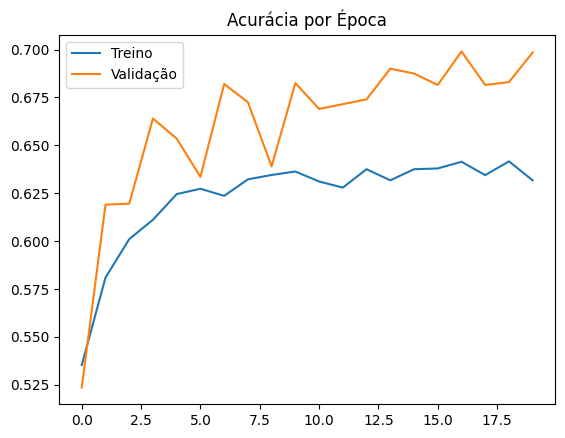

In [23]:
loss, acc = model.evaluate(test_dataset)
print(f"Accuracy com ResNet50 + Dropout + Aug: {acc:.2f}")

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.title("Acurácia por Época")
plt.show()

# **Resultados**

Comparado a um modelo anterior criado do zero com camadas convolucionais simples, o modelo com ResNet50 apresentou melhor desempenho, especialmente na validação. Ele treinou mais rápido, com menos overfitting e maior acurácia geral. As técnicas de data augmentation e regularização também contribuíram para uma melhor generalização do modelo.



# **Referências**

ABADI, M. et al. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. 2015. Disponível em: https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50. Acesso em: 03 jun. 2025.

ABADI, M. et al. TensorFlow: tf.image Module. 2015. Disponível em: https://www.tensorflow.org/api_docs/python/tf/image. Acesso em: 03 jun. 2025.

CHOLLET, F. et al. Keras API Reference: ImageDataGenerator. 2015. Disponível em: https://keras.io/api/preprocessing/image/#imagedatagenerator-class. Acesso em: 03 jun. 2025.

KRIZHEVSKY, A. Learning Multiple Layers of Features from Tiny Images. 2009. Technical Report, University of Toronto. Disponível em: https://www.cs.toronto.edu/~kriz/cifar.html. Acesso em: 03 jun. 2025.

---

In [ ]:
#@title **Avaliação**
Resumo = 10 #@param {type:"slider", min:0, max:10, step:1}

Descricao_solucao = 7 #@param {type:"slider", min:0, max:10, step:1}

Implementacao = 9 #@param {type:"slider", min:0, max:10, step:1}

Resultados = 6 #@param {type:"slider", min:0, max:10, step:1}

Referencias = 7 #@param {type:"slider", min:0, max:10, step:1}

Geral = 7 #@param {type:"slider", min:0, max:10, step:1}








In [ ]:
#@title **Nota Final**
nota = Resumo + Descricao_solucao + Implementacao + Resultados + Referencias + Geral

nota = nota / 6

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

Nota final do trabalho 7.7



,tia,nome,nota
0,1115665,ADRIANA FUJITA,7.7
1,1115677,DANIEL HENRIQUE,7.7
